<a href="https://colab.research.google.com/github/NathaliL/Recidivism-Prediction/blob/main/Recidivism_Prediction_using_Recidivism_Beginning_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
import pandas as pd
import tensorflow as tf
import keras
import warnings
import pandas as pd
import time
start_time = time.time()
df = pd.read_csv('/content/Recidivism Beginning 2008.csv')
df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,labels
0,2008,UNKNOWN,MALE,55.0,Not Returned,0.0
1,2008,ALBANY,MALE,16.0,Returned Parole Violation,1.0
2,2008,ALBANY,MALE,17.0,Not Returned,0.0
3,2008,ALBANY,MALE,17.0,Returned Parole Violation,1.0
4,2008,ALBANY,MALE,18.0,Not Returned,0.0


In [ ]:
# Identify the text and label columns
# Assume the column 'text_column' contains the text data you want to use with BERT
texts = (df['Gender'].astype(str) + ' ' +
         df['Release Year'].astype(str) + ' ' +
         df['Age at Release'].astype(str) + ' ' +
         df['Return Status'].astype(str) + ' ' +
         df['County of Indictment'].astype(str)).tolist()
labels = df['labels']  #  the column containing labels

In [ ]:
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
import torch
import numpy as np
import pandas as pd

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_embeddings(text_list, batch_size=32):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [ ]:




# Initialize model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Set your dataset and batch size
file_path = '/content/Recidivism Beginning 2008.csv'
batch_size = 10000  # Adjust based on your memory capacity

# Read the dataset in chunks
chunk_iter = pd.read_csv(file_path, chunksize=batch_size)

for i, chunk in enumerate(chunk_iter):
    texts = (chunk['Gender'].astype(str) + ' ' +
             chunk['Release Year'].astype(str) + ' ' +
             chunk['Age at Release'].astype(str) + ' ' +
             chunk['Return Status'].astype(str) + ' ' +
             chunk['County of Indictment'].astype(str)).tolist()
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()

    # Save embeddings
    np.save(f'embeddings_batch_{i}.npy', embeddings)

    # Clear memory
    del inputs, outputs, embeddings
    torch.cuda.empty_cache()  # If using GPU

# Load the embeddings that were saved
all_embeddings = []
batch_count = 0
while True:
    try:
        embeddings = np.load(f'embeddings_batch_{batch_count}.npy')
        all_embeddings.append(embeddings)
        batch_count += 1
    except FileNotFoundError:
        break

# Combine all embeddings into one array
X = np.vstack(all_embeddings)

# Load your labels
y = df['labels'].values  # Ensure this matches your dataset

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load your dataset
df = pd.read_csv('/content/Recidivism Beginning 2008.csv')

# Initialize an empty list to store the embeddings
all_embeddings = []

# Load only the 20 embedding files
for i in range(20):  # Adjusted to 20 files
    try:
        embeddings = np.load(f'embeddings_batch_{i}.npy')
        all_embeddings.append(embeddings)
    except FileNotFoundError:
        print(f"File embeddings_batch_{i}.npy not found, skipping.")

# Combine all loaded embeddings into one array
if all_embeddings:
    X = np.vstack(all_embeddings)
else:
    print("No embeddings were loaded.")

# Ensure your labels are aligned with the embeddings
y = df['labels'].values[:X.shape[0]]  # Make sure to only use labels that correspond to the loaded embeddings

# Option 1: Remove rows with NaN in labels
mask = ~np.isnan(y)
X = X[mask]
y = y[mask]

# Define the function for k-fold cross-validation
def perform_k_fold_cv(model, X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        predictions = model.predict(X_val)

        accuracy_scores.append(accuracy_score(y_val, predictions))
        precision_scores.append(precision_score(y_val, predictions, average='binary'))
        recall_scores.append(recall_score(y_val, predictions, average='binary'))
        f1_scores.append(f1_score(y_val, predictions, average='binary'))

    return accuracy_scores, precision_scores, recall_scores, f1_scores

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Perform K-Fold Cross-Validation for K=5
#acc_k5, prec_k5, recall_k5, f1_k5 = perform_k_fold_cv(model, X, y, 5)

# Perform K-Fold Cross-Validation for K=10
acc_k10, prec_k10, recall_k10, f1_k10 = perform_k_fold_cv(model, X, y, 10)

# Print results for K=5
#print("\nK=5 Accuracy Scores:", acc_k5)
#print("K=5 Precision Scores:", prec_k5)
#print("K=5 Recall Scores:", recall_k5)
#print("K=5 F1 Scores:", f1_k5)
#print("K=5 Mean Accuracy:", np.mean(acc_k5))
#print("K=5 Mean Precision:", np.mean(prec_k5))
#print("K=5 Mean Recall:", np.mean(recall_k5))
#print("K=5 Mean F1 Score:", np.mean(f1_k5))

# Print results for K=10
print("\nK=10 Accuracy Scores:", acc_k10)
print("K=10 Precision Scores:", prec_k10)
print("K=10 Recall Scores:", recall_k10)
print("K=10 F1 Scores:", f1_k10)
print("K=10 Mean Accuracy:", np.mean(acc_k10))
print("K=10 Mean Precision:", np.mean(prec_k10))
print("K=10 Mean Recall:", np.mean(recall_k10))
print("K=10 Mean F1 Score:", np.mean(f1_k10))



K=10 Accuracy Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
K=10 Precision Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
K=10 Recall Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
K=10 F1 Scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
K=10 Mean Accuracy: 1.0
K=10 Mean Precision: 1.0
K=10 Mean Recall: 1.0
K=10 Mean F1 Score: 1.0


Label distribution: {0.0: 116611, 1.0: 83389}


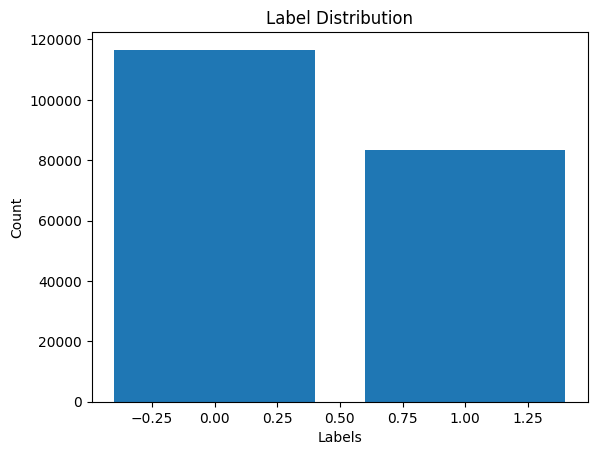

In [ ]:
# Check for class distribution in labels
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))

# Plot the distribution (optional, for visualization)
import matplotlib.pyplot as plt

plt.bar(unique, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def perform_k_fold_cv_with_confusion_matrix(model, X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    confusion_matrices = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        predictions = model.predict(X_val)

        accuracy_scores.append(accuracy_score(y_val, predictions))
        precision_scores.append(precision_score(y_val, predictions))
        recall_scores.append(recall_score(y_val, predictions))
        f1_scores.append(f1_score(y_val, predictions))

        # Generate and store the confusion matrix for each fold
        cm = confusion_matrix(y_val, predictions)
        confusion_matrices.append(cm)

    return accuracy_scores, precision_scores, recall_scores, f1_scores, confusion_matrices

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Perform K-Fold Cross-Validation for K=5 and generate confusion matrices
acc_k5, prec_k5, recall_k5, f1_k5, confusion_matrices = perform_k_fold_cv_with_confusion_matrix(model, X, y, 5)

# Print the confusion matrices for each fold
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i+1}:\n{cm}\n")

# Optionally, you can average the confusion matrices if you need an overall view
average_cm = np.mean(confusion_matrices, axis=0)
print(f"Average Confusion Matrix:\n{average_cm}")


Confusion Matrix for Fold 1:
[[23384     0]
 [    0 16616]]

Confusion Matrix for Fold 2:
[[23239     0]
 [    0 16761]]

Confusion Matrix for Fold 3:
[[23346     0]
 [    0 16654]]

Confusion Matrix for Fold 4:
[[23374     0]
 [    0 16626]]

Confusion Matrix for Fold 5:
[[23268     0]
 [    0 16732]]

Average Confusion Matrix:
[[23322.2     0. ]
 [    0.  16677.8]]
